# Checkpoint 4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfinv
from scipy.integrate import quad
from iminuit import Minuit

## Problem #1

##### Creating Classes:

In [3]:
class linear:
    def __init__(self, intercept, slope, lolimit, hilimit):
        self.intercept = intercept
        self.slope = slope
        
        self.lolimit = lolimit
        self.hilimit = hilimit

        self.mass = []
        self.maxval = self.evaluate(self.lolimit if self.slope < 0. else self.hilimit)
       
    def evaluate(self, t):
        return self.intercept + self.slope*t
    
    def integral(self):
        return quad(self.evaluate, self.lolimit, self.hilimit)[0]

    def next(self):        
        doLoop = True
        while (doLoop):
            # start with uniform random number in [lolimit , hilimit)
            x = np.random.uniform(self.lolimit, self.hilimit)
            y1 = self.evaluate(x)
            y2 = np.random.uniform(0, self.maxval)

            if (y2 < y1):
                filtered_x = x
                self.mass.append(filtered_x)
                return filtered_x

In [4]:
class gaussian:
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma

    def next(self):
        return np.random.normal(self.mean, self.sigma)

    def evaluate(self, x):
        return np.exp(-(x-self.mean)**2/(2*(self.sigma**2))) #1/(self.sigma*np.sqrt(2.*np.pi)))*

    def integral(self, lolimit, hilimit):
        return quad(self.evaluate, lolimit, hilimit)[0]

    def inv_integral(self, lolimit, hilimit):
        return erfinv(1 - self.integral(lolimit, hilimit))*np.sqrt(2)

In [5]:
class signalWithBackground:
    def __init__(self, mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX):
        self.sig_fraction = sig_fraction
        
        # Initalise classes
        self.signal = gaussian(mean, sigma)
        self.background = linear(intercept, slope, XMIN, XMAX)
        
        self.mass_sig = []
        self.mass_bgd = []
        self.mass = []

    # Draw random number form distribution
    def next(self):
        q = np.random.uniform()

        if (q < self.sig_fraction):
            # if here , we will draw x from signal distribution
            filtered_x = self.signal.next()
            self.mass_sig.append(filtered_x)
        else:
            # if here , we will draw x from background distribuion
            filtered_x = self.background.next()
            self.mass_bgd.append(filtered_x)
            
        self.mass.append(filtered_x)
        return filtered_x

In [6]:
XMIN = 0.
XMAX = 20.
intercept = 20.
slope = -1.

# signal parameters
mean = 10.
sigma = 0.5
# chose number of bins that is appropriate for the size of the statistics sample
NBINS = 100

In [7]:
# Main code to generate and plot a single experiment
def singleToy(mean, sigma, intercept, slope, XMIN, XMAX, nevents_sig=300, nevents_bgd=10000):
    sig_fraction = nevents_sig/(nevents_bgd+nevents_sig)
    
    # Create the pdf
    pdf = signalWithBackground(mean, sigma, sig_fraction, intercept, slope, XMIN, XMAX)
    
    for i in range(nevents_sig + nevents_bgd): pdf.next()

    # retrieve the mass values for signal, background and their sum
    data = pdf.mass
    sig_data = pdf.mass_sig
    bgd_data = pdf.mass_bgd

    # plot things on same page
    myRange = (XMIN, XMAX)
    fig, axs = plt.subplots(3, 1, figsize=(5,9), sharex='col', dpi=150)

    axs[0].set_title("Signal distribution (" + str(len(sig_data)) + " entries)")
    axs[1].set_title("Background distribution (" + str(len(bgd_data)) + " entries)")
    axs[2].set_title("Total distribution (" + str (len(data)) + " entries )")
    axs[2].set_xlabel('X')

    axs[0].hist(sig_data, bins=NBINS, range=myRange)
    axs[1].hist(bgd_data, bins=NBINS)
    axs[2].hist(data, bins=NBINS)

    fig.tight_layout()
    plt.show()
    #plt.savefig('Example1.pdf')

    return pdf

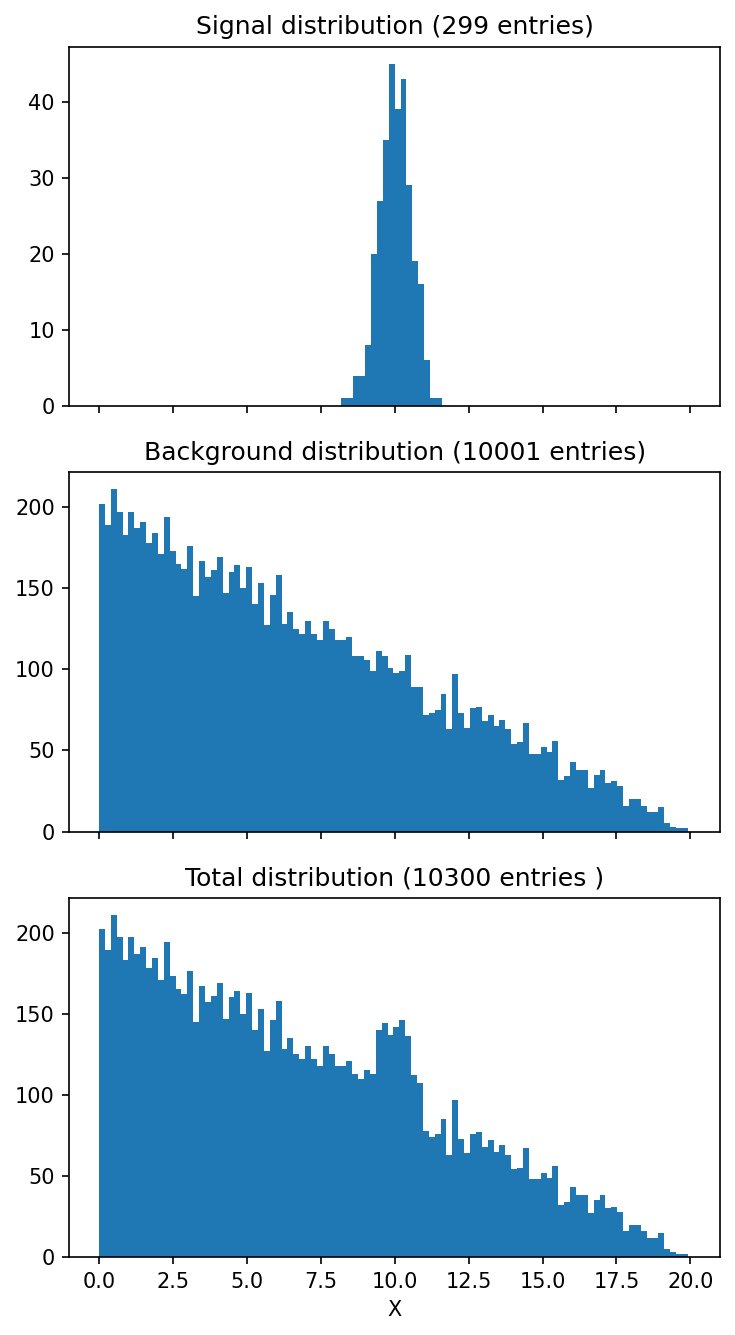

In [8]:
pdf = singleToy(mean, sigma, intercept, slope, XMIN, XMAX)

## Problem #2

In [9]:
# Setting lambda(l) and k(limit) values for p-value calculation
l = 10000
limit = 10300
bkg_guass = gaussian(l, np.sqrt(l))

# Using an extremely large number in the high limit to constrain the area under the curve
# If high limit is set to np.inf; the function blows up and can't find the area
p_val = bkg_guass.integral(limit, np.inf)/bkg_guass.integral(0, 90000)
print("The p-value found for a background process at {0} to fluctuate to {1} is:".format(l, limit), p_val)

The p-value found for a background process at 10000 to fluctuate to 10300 is: 0.0013498980316300165


In [10]:
z_score = erfinv(1 - p_val)*np.sqrt(2)
print("The Z-score for a background process at {0} to fluctuate to {1} is:".format(l, limit), z_score) # No of sigmas away from the mean

The Z-score for a background process at 10000 to fluctuate to 10300 is: 3.205154920598955


## Problem #3

In [11]:
data = [x for x in pdf.mass_bgd if 5 <= x <= 15]
print("The backgound data is about", len(data)/len(pdf.mass_bgd)*100, "percent of the original data.")

The backgound data is about 49.65503449655034 percent of the original data.


In [12]:
# Updating the lambda and k values
l = 5000
limit = 5300
bkg_guass = gaussian(l, np.sqrt(l))
p_val = bkg_guass.integral(5300, np.inf)/bkg_guass.integral(0, 14000)
print("The p-value found for a background process at {0} to fluctuate to {1} is:".format(l, limit), p_val)

The p-value found for a background process at 5000 to fluctuate to 5300 is: 1.1045248499290454e-05


In [13]:
z_score = erfinv(1 - p_val)*np.sqrt(2)
print("The Z-score for the for a background process at {0} to fluctuate to {1} is:".format(l, limit), z_score)

The Z-score for the for a background process at 5000 to fluctuate to 5300 is: 4.395628921087773


The deviation is seen to be more when the data is halfed due the exponential decrease in the data.

## Problem #4

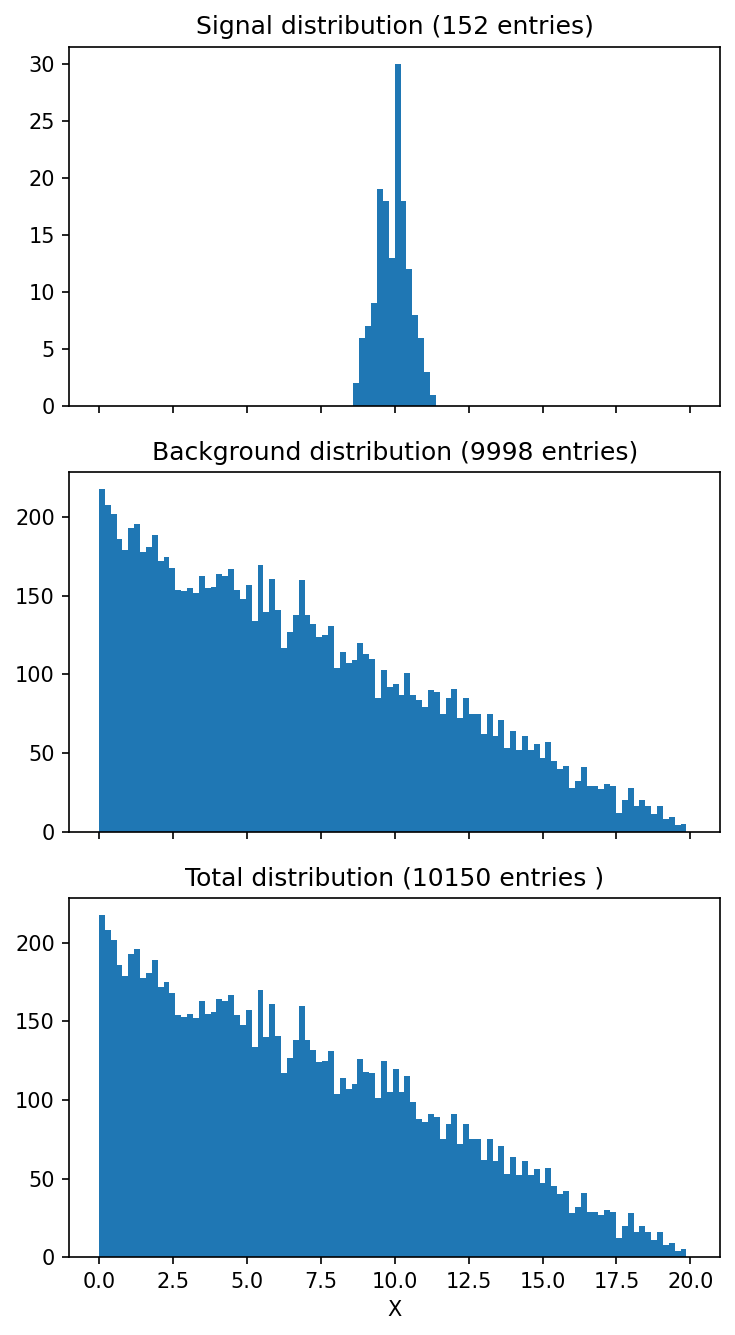

In [14]:
new_pdf = singleToy(mean, sigma, intercept, slope, XMIN, XMAX, nevents_sig=150, nevents_bgd=10000)

In [15]:
def get_hist_info(data):
    # Derive the appropriate numbers in the data
    # Here shifting x values to the center of the bins and
    # getting the height of the bin for y values
    
    n, bins = np.histogram(data, bins=NBINS)
    bins = [(bins[i] + bins[i+1])/2. for i in range(len(bins)-1)]
    return bins, n

In [16]:
# Rewriting the intial parameters
XMIN = 5.
XMAX = 15.
intercept = 20.
slope = -1.

# signal parameters
mean = 10.
sigma = 0.5
# chose number of bins that is appropriate for the size of the statistics sample
NBINS = 100

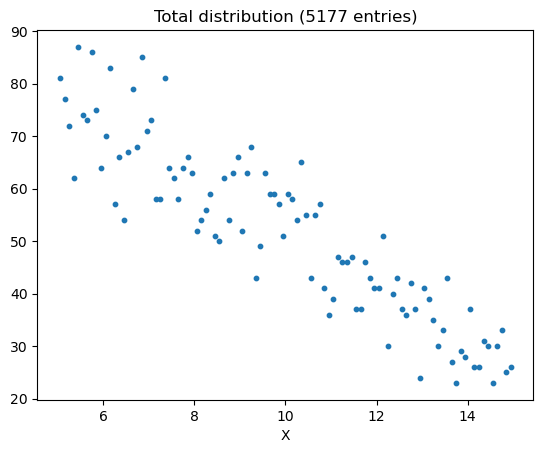

In [17]:
obs_data = {}

data = [x for x in new_pdf.mass if XMIN <= x <= XMAX]
obs_data['x'], obs_data['y'] = get_hist_info(data)

# Sanity check
plt.scatter(obs_data['x'], obs_data['y'], s=10)
plt.title("Total distribution (" + str (len(data)) + " entries)")
plt.xlabel('X')
plt.show()

##### Null Hypothesis (H0)

In [25]:
def min_chi2_H0(intercept, slope): 
    # Defined a Minuit specific funtion for chi^2 minimisation
    # dor null Hypothesis only, therefore set with only linear model
    
    model = linear(intercept, slope, XMIN, XMAX)

    total = 0.
    for x, N_obs in zip(obs_data['x'], obs_data['y']):
        N_exp = model.evaluate(x)
        if N_exp < 0.:
            N_exp = 1e-3
        total += (N_exp - N_obs + (N_obs*np.log(N_obs/N_exp)))
    return (2*total)


startvals_H0 = {
    'intercept': intercept,
    'slope': slope,
}

H0 = Minuit(min_chi2_H0, **startvals_H0)
H0.migrad()  # find minimum
H0.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 90.47                      │              Nfcn = 79               │
│ EDM = 3.95e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ intercept │   104.1   │    2.7    │            │            │         │         │       │
│ 1 │ slope     │   -5.23   │   0.24    │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────┐
│           │ intercept     slope │
├───────────┼─────────────────────┤
│ intercept │      7.36    -0.632 │
│     slope │    -0.632     0.058 │
└───────────┴─────────────────────┘

##### Alt Hypothesis (H1)

In [23]:
def min_chi2_H1(intercept, slope):
    # Defined a Minuit specific funtion for chi^2 minimisation
    # for alternative Hypothesis only, therefore set with linear + guassian model

    lin = linear(intercept, slope, XMIN, XMAX)
    gauss = gaussian(mean, sigma)
    
    total = 0.
    for x, N_obs in zip(obs_data['x'], obs_data['y']):
        N_exp = lin.evaluate(x) + gauss.evaluate(x)
        if N_exp < 0.:
            N_exp = 1e-3
        total += (N_exp - N_obs + (N_obs*np.log(N_obs/N_exp)))
        
    return (2*total)

startvals_H1 = {
    'intercept':intercept,
    'slope':slope,
}

H1 = Minuit(min_chi2_H1, **startvals_H1)
H1.migrad()  # find minimum
H1.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.78                      │              Nfcn = 79               │
│ EDM = 4.56e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ intercept │   103.8   │    2.7    │            │            │         │         │       │
│ 1 │ slope     │   -5.22   │   0.24    │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────┐
│           │ intercept     slope │
├───────────┼─────────────────────┤
│ intercept │      7.33    -0.629 │
│     slope │    -0.629    0.0577 │
└───────────┴─────────────────────┘

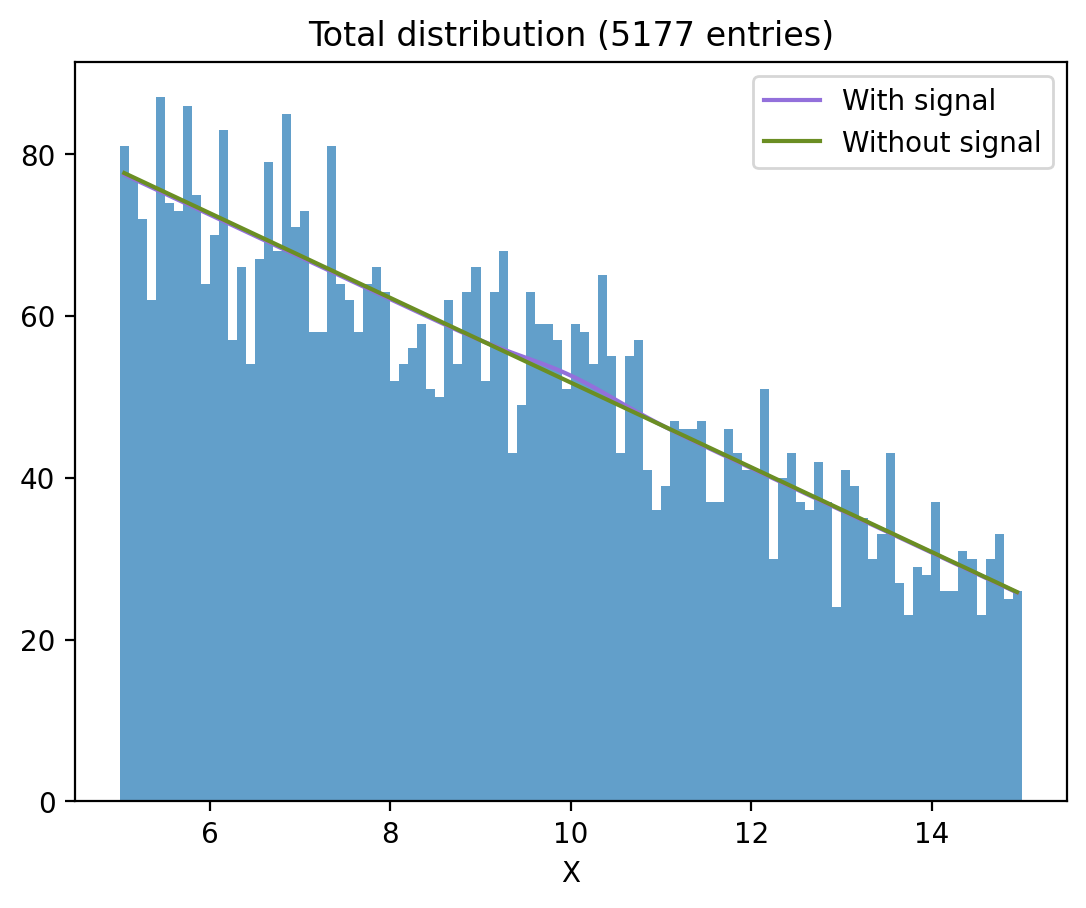

In [20]:
# Accessing the data from Minuit class and calculating models
lin_0 = linear(H0.values['intercept'], H0.values['slope'], XMIN, XMAX)
lin_1 = linear(H1.values['intercept'], H1.values['slope'], XMIN, XMAX)
gauss = gaussian(mean, sigma)

# Calculating values using model from Minuit fitted paramters
y0 = []
y1 = []
for x in obs_data['x']:
    y0.append(lin_0.evaluate(x))
    y1.append(lin_1.evaluate(x) + gauss.evaluate(x))

plt.figure(dpi=200)
plt.hist(data, bins=NBINS, alpha=0.7)
plt.plot(obs_data['x'], y1, label='With signal', color='mediumpurple')
plt.plot(obs_data['x'], y0, label='Without signal', color='olivedrab')


plt.title("Total distribution (" + str (len(data)) + " entries)")
plt.xlabel('X')
plt.legend()
plt.show()

#### Using Wilk's Theorem:

In [142]:
tot_H0 = lin_0.integral()
tot_H1 = lin_1.integral() + gauss.integral(XMIN, XMAX)

p_val = -2*(np.log(tot_H1) - np.log(tot_H0))
print("The p-value found using Wilk's Theorem on the hypothesis test is:", p_val)

The p-value found using Wilk's Theorem on the hypothesis test is: 0.0006112903527881741


In [143]:
z_score = erfinv(1 - p_val)*np.sqrt(2)
print("The Z-score for the hypothesis test is:", z_score)

The Z-score for the hypothesis test is: 3.4265548216598054
